# CREA-CI historical phenotypic wheat data analysis

## Load packages, custom functions and data

In [1]:
library(readxl)
library(tidyverse)
library(multtest)
library(asreml)

source("../custom_functions.r")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:lubridate’:

    intersect, setdiff, union


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
  

Online License checked out Tue Apr 30 21:05:18 2024


Loading ASReml-R version 4.2




In [2]:
data_total <- preprocess("CREA-historic.xlsx")
write_csv(data_total, "CREA_wheat.csv")
genotypes <- distinct(data_total["accenumb"]) |> rename("genotype" = "accenumb")
cat("Wheat data:\n", nrow(data_total), "observations\n", nrow(genotypes), "genotypes\n", nrow(distinct(data_total["campaign"])), "campaigns\n\n")
summary(data_total[c("days_to_heading", "plant_height", "thousand_kernel_weight")])

Wheat data:
 7947 observations
 1473 genotypes
 15 campaigns



 days_to_heading  plant_height    thousand_kernel_weight
 Min.   : 89.0   Min.   :  0.00   Min.   :11.00         
 1st Qu.:118.0   1st Qu.: 76.00   1st Qu.:38.50         
 Median :124.0   Median : 92.00   Median :44.00         
 Mean   :125.1   Mean   : 96.27   Mean   :43.67         
 3rd Qu.:130.0   3rd Qu.:114.00   3rd Qu.:49.50         
 Max.   :226.0   Max.   :406.00   Max.   :83.80         
 NA's   :14      NA's   :53       NA's   :4608          

## Subset data, remove missing values and singletons, make factors

In [3]:
data_sub_HT <- data_total |> make_data_sub("days_to_heading")
data_sub_PH <- data_total |> make_data_sub("plant_height")
data_sub_TKW <- data_total |> make_data_sub("thousand_kernel_weight")
data_sub_PM <- data_total |> make_data_sub("powdery_mildew")
data_sub_LR<- data_total |> make_data_sub("leaf_rust")
# YR has observations in only one campaign so cannot be analysed here
data_sub_ST <- data_total |> make_data_sub("septoria_tritici_ssp")
data_sub_PC <- data_total |> make_data_sub("protein_content")
data_sub_SV <- data_total |> make_data_sub("sds_sedimentation_volume")

7237 days_to_heading rows kept
7591 plant_height rows kept
3131 thousand_kernel_weight rows kept
2687 powdery_mildew rows kept
3186 leaf_rust rows kept
1729 septoria_tritici_ssp rows kept
2075 protein_content rows kept
2029 sds_sedimentation_volume rows kept


## Visualise trait values 

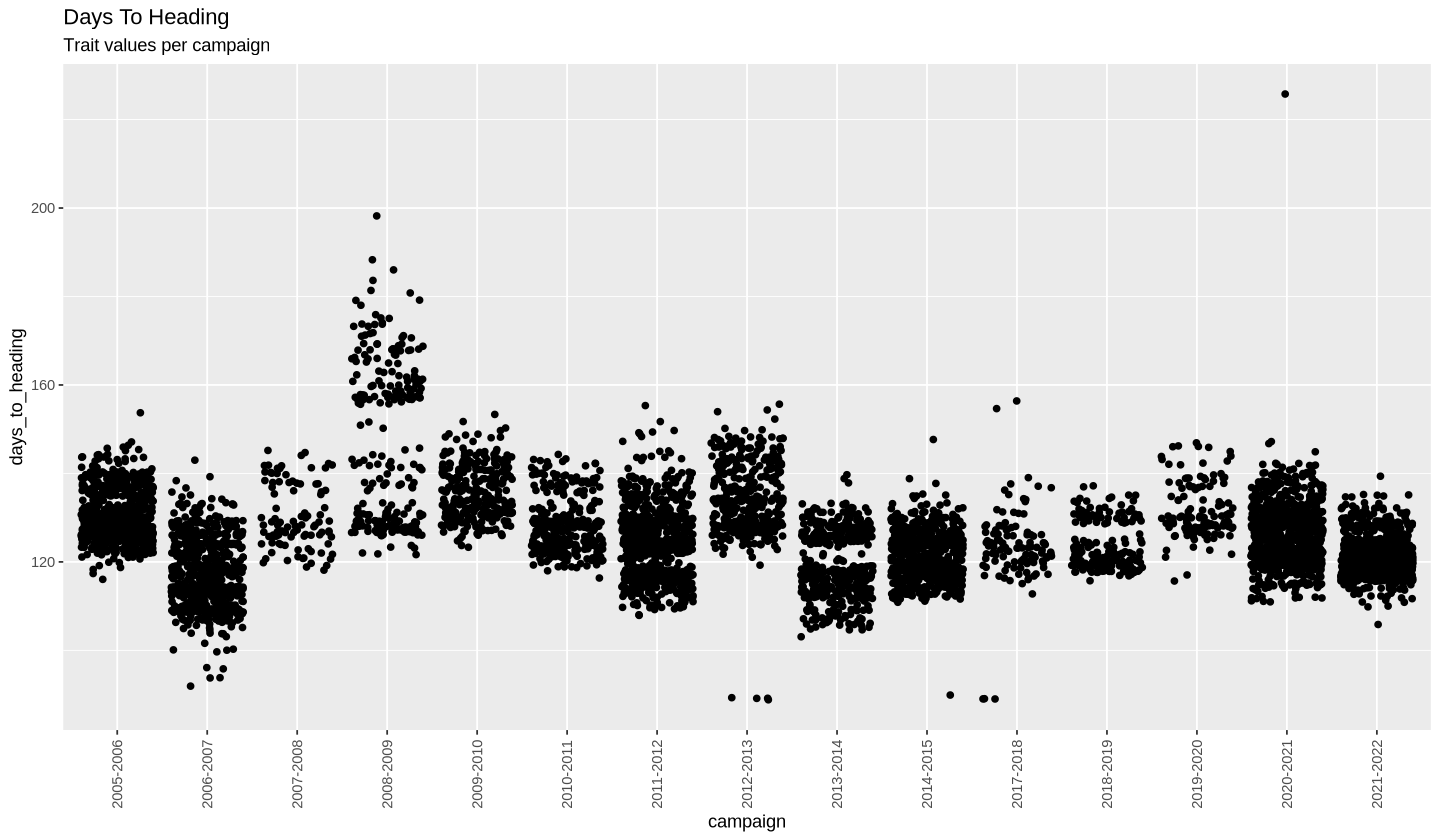

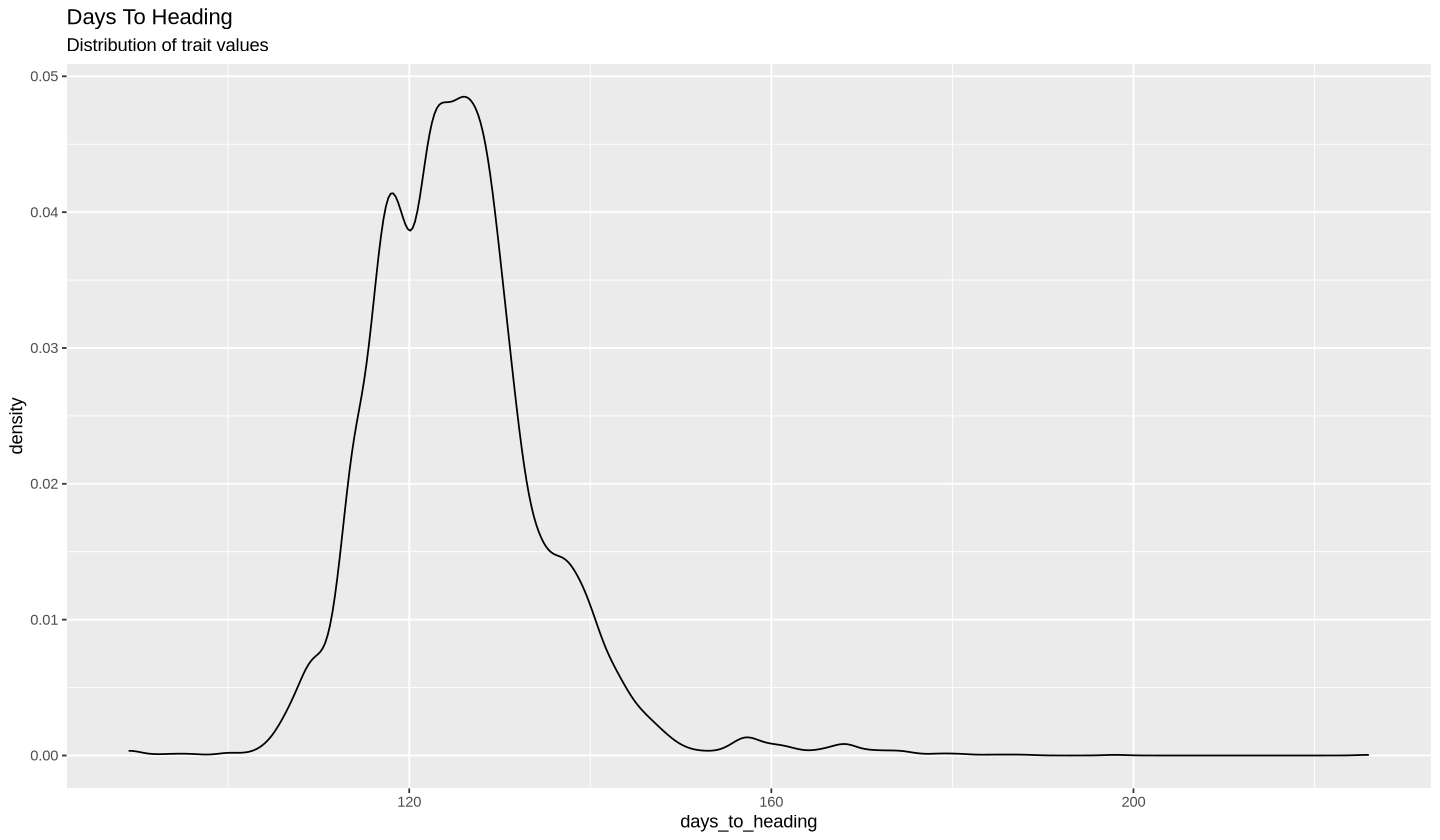

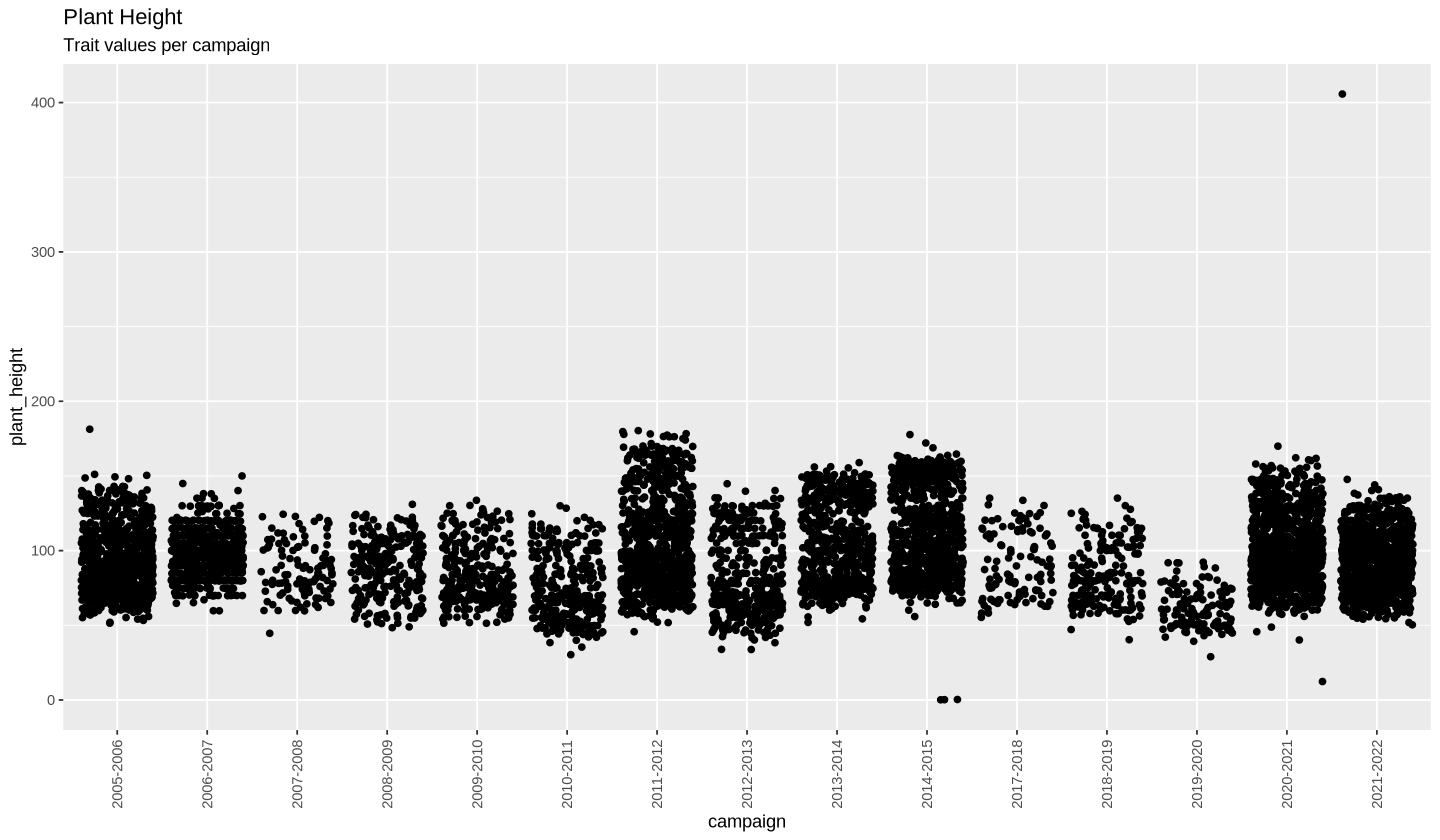

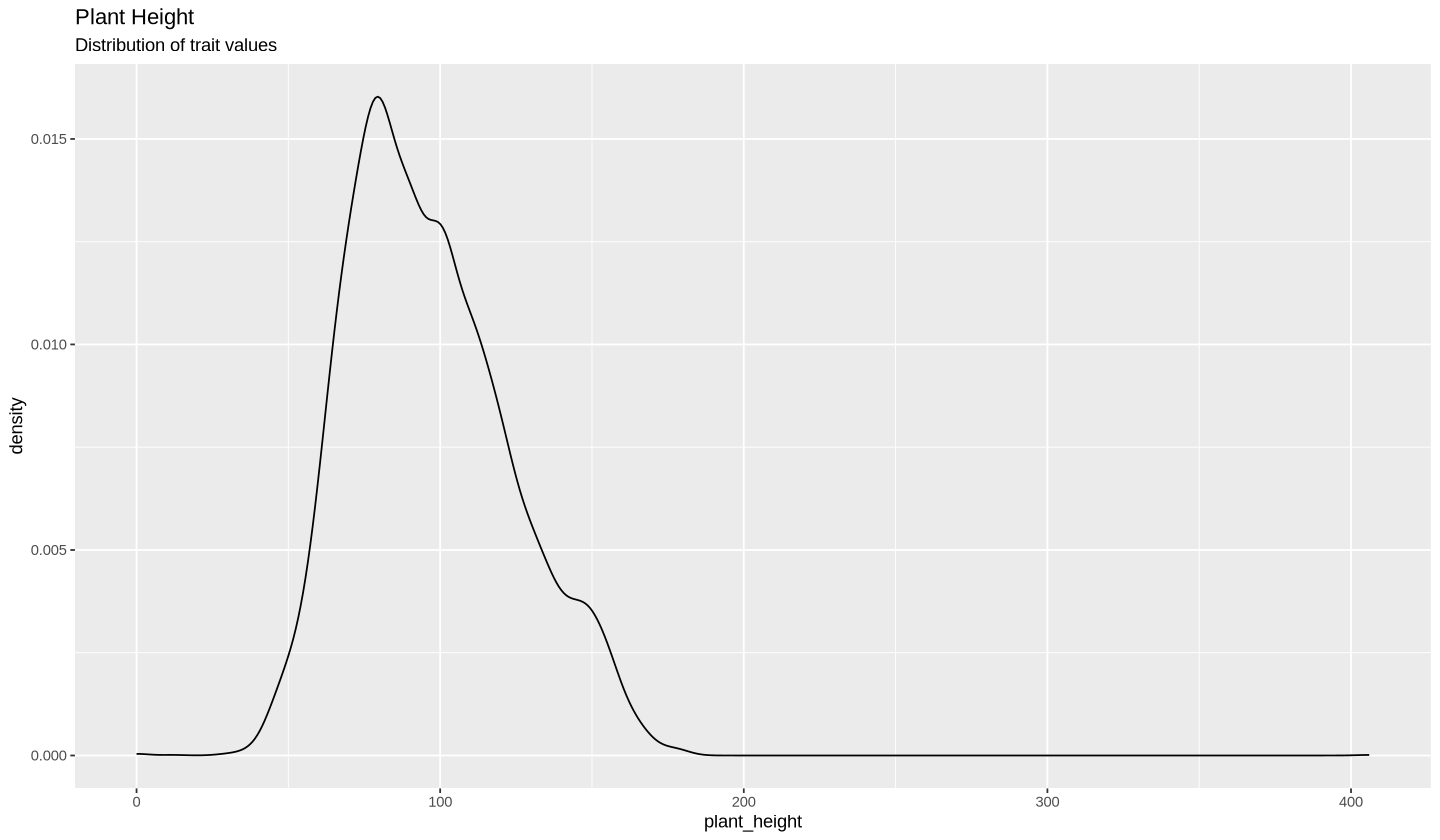

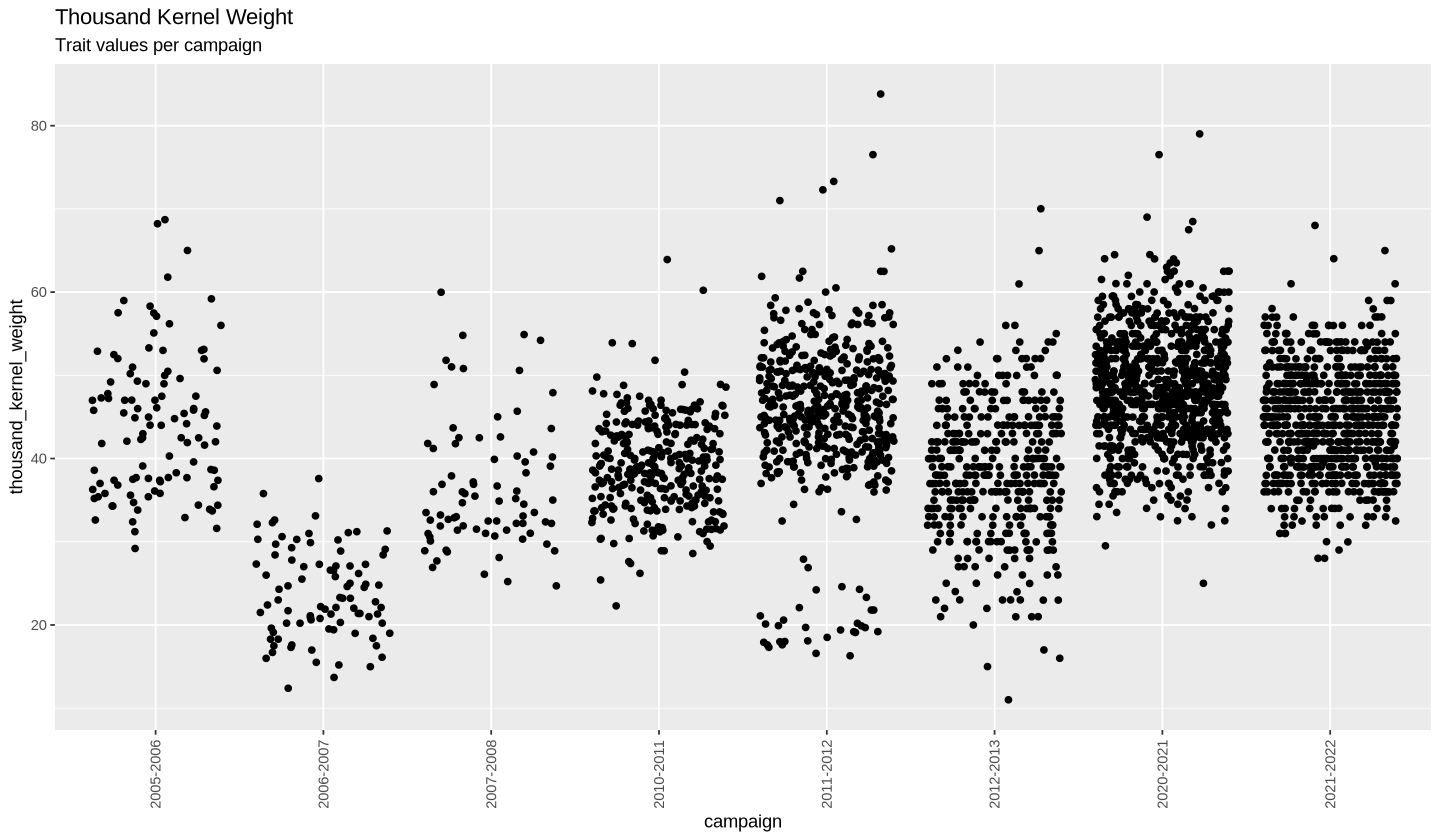

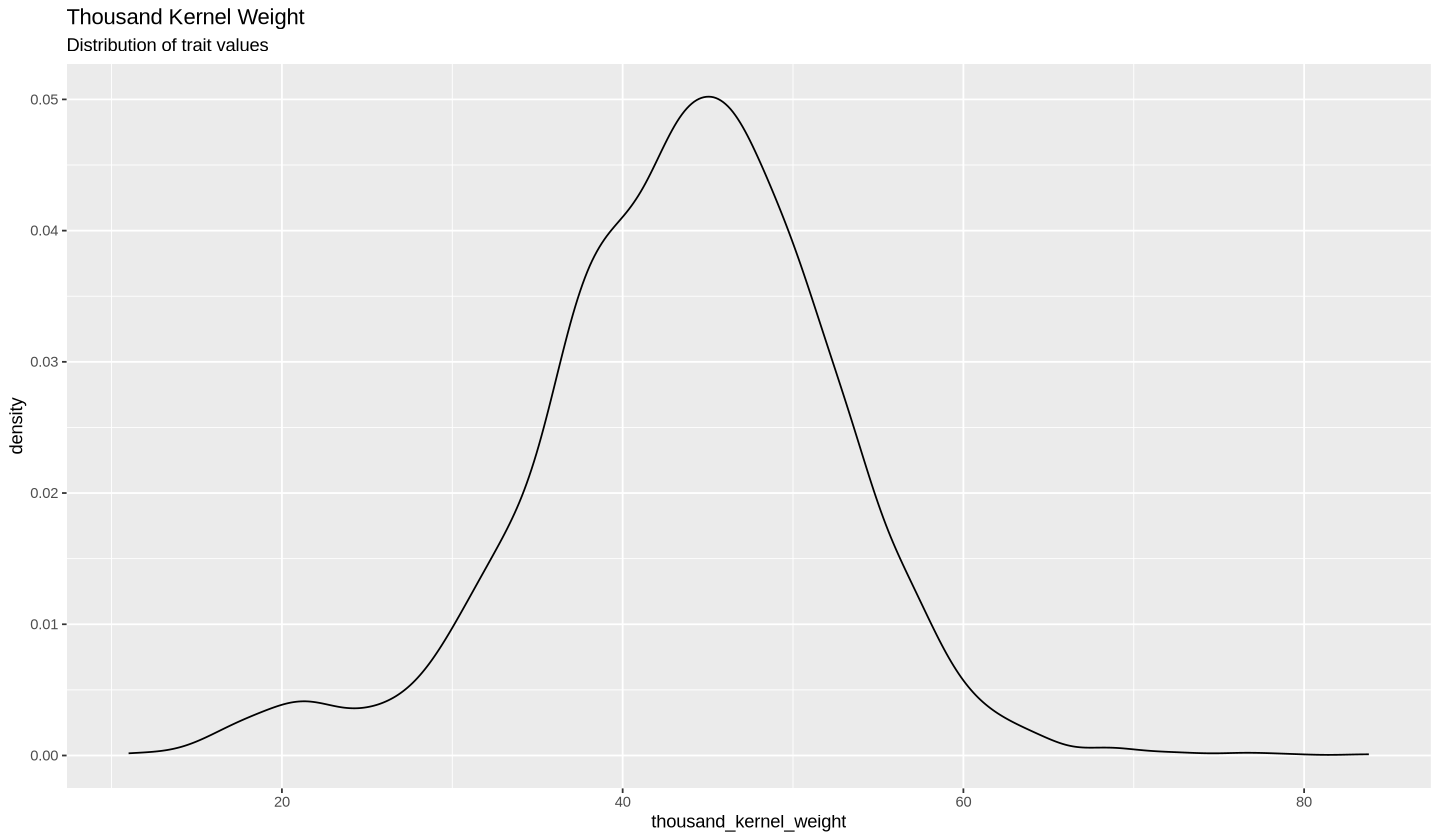

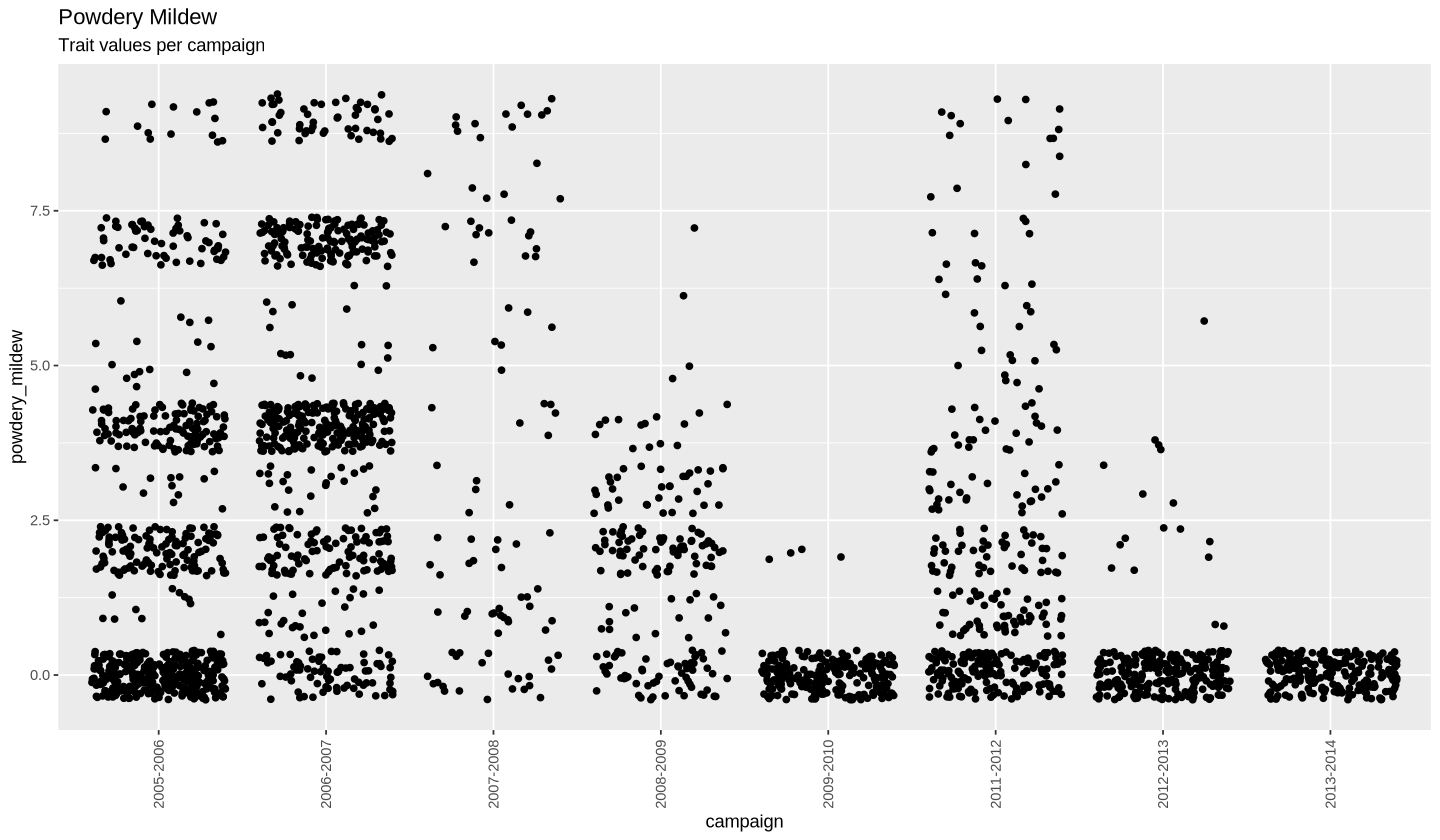

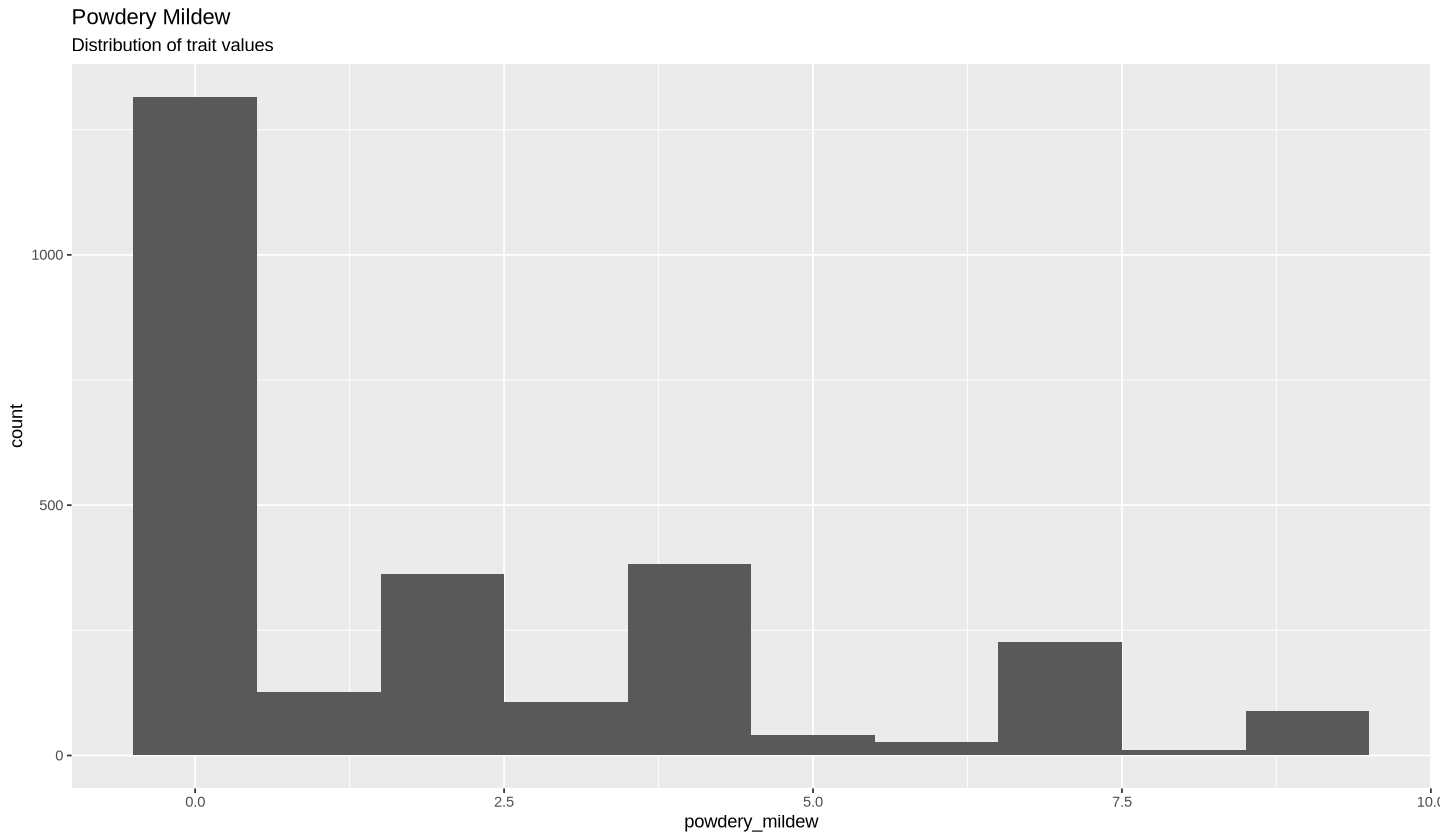

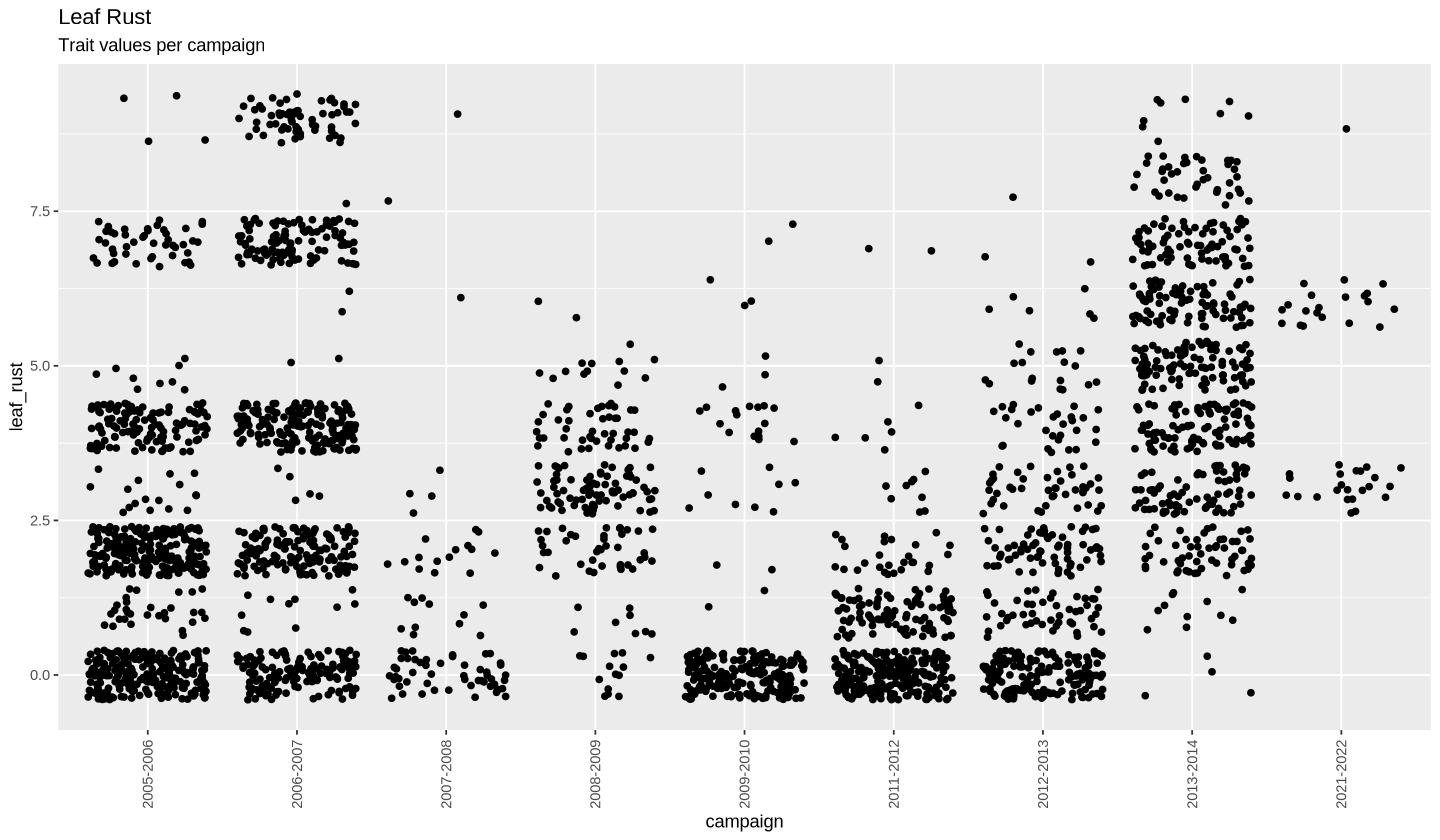

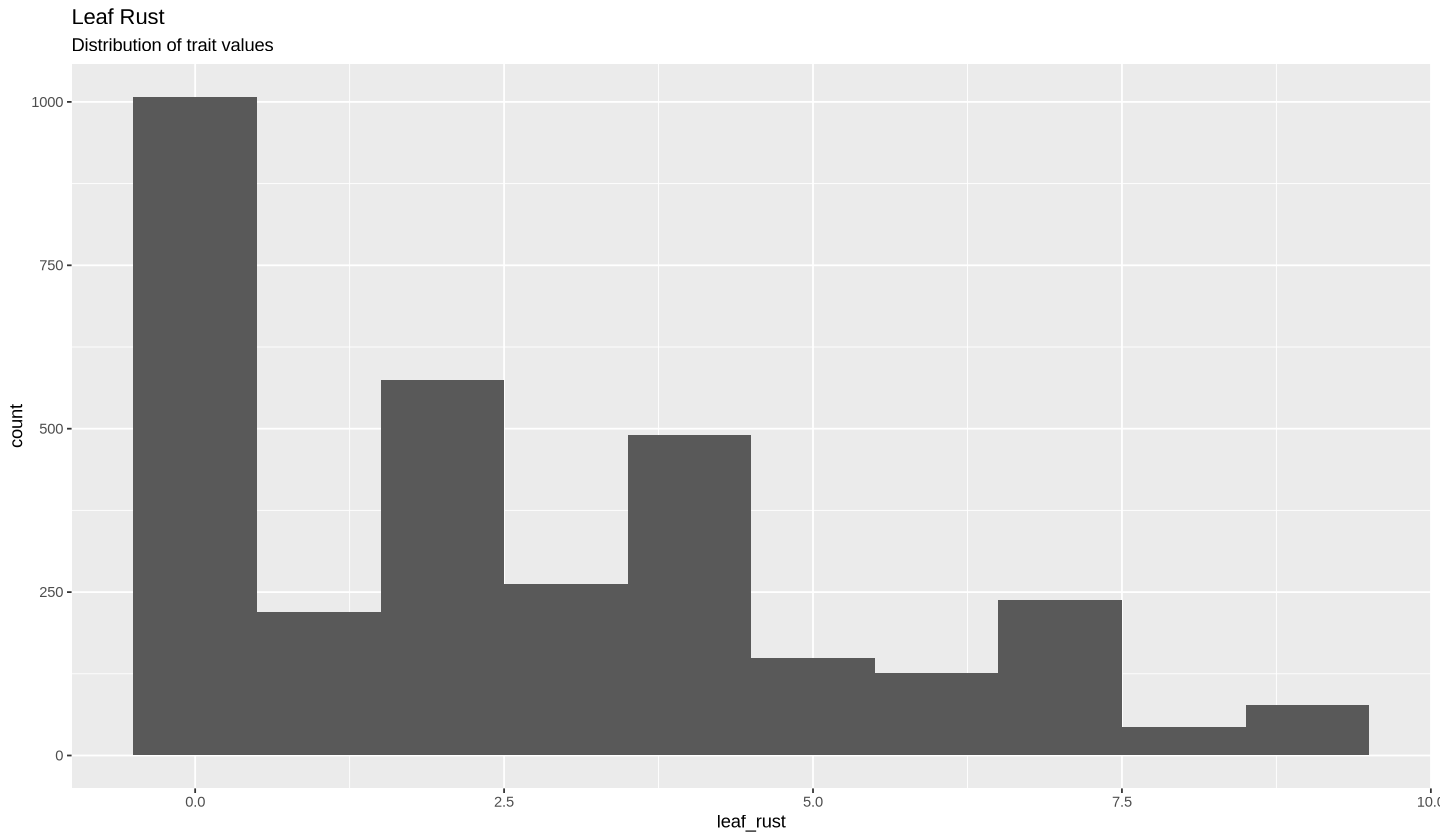

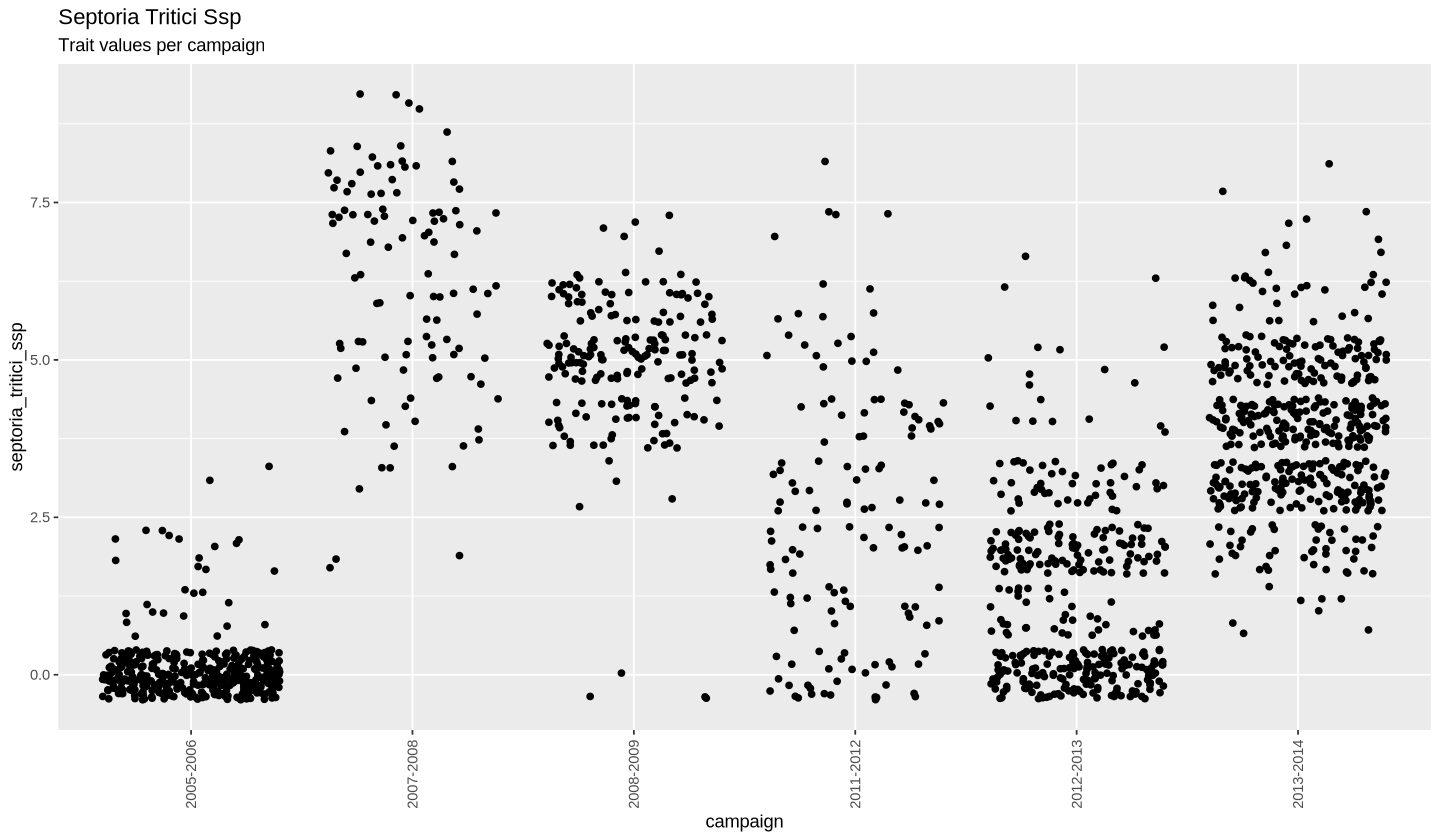

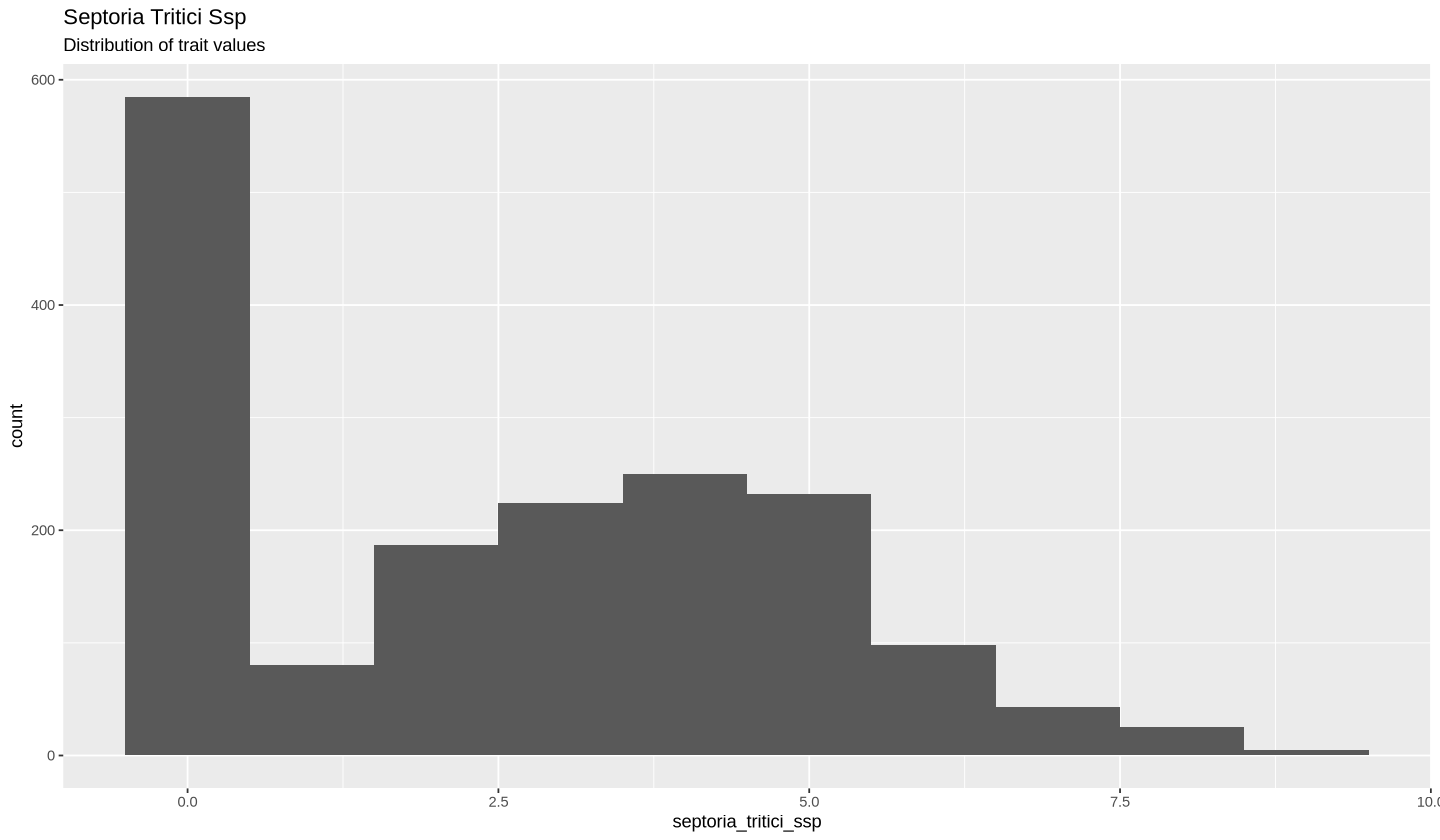

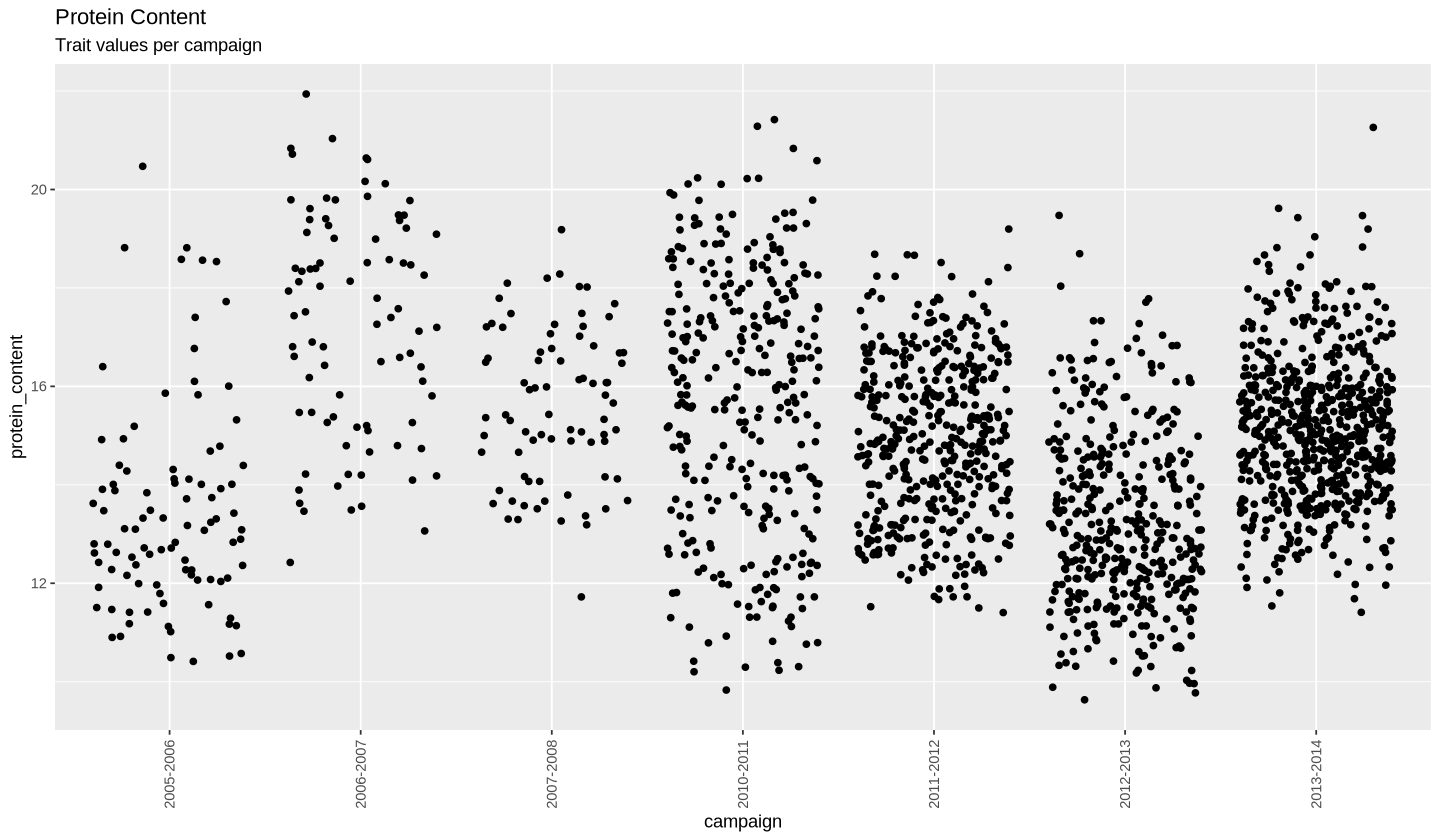

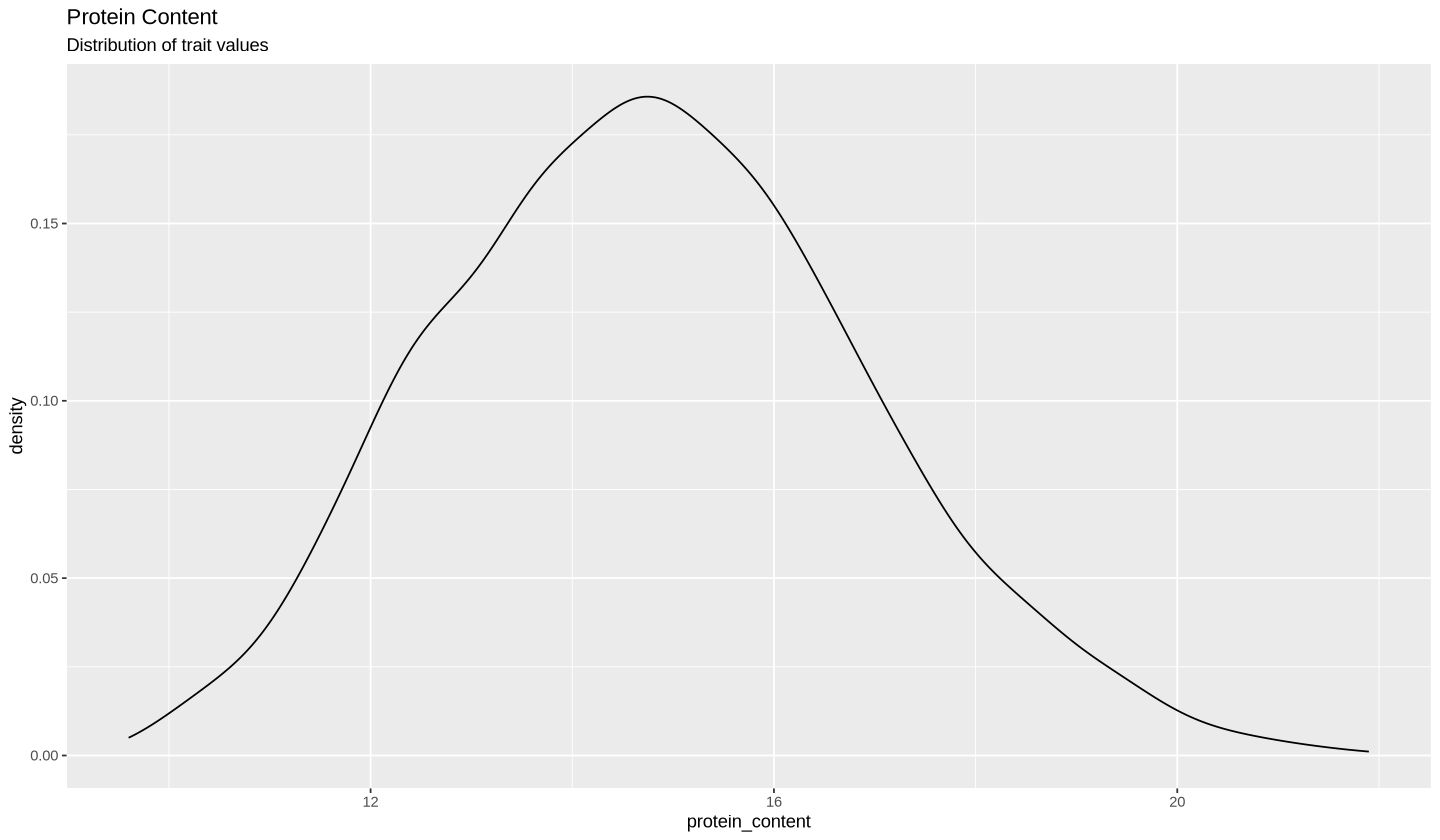

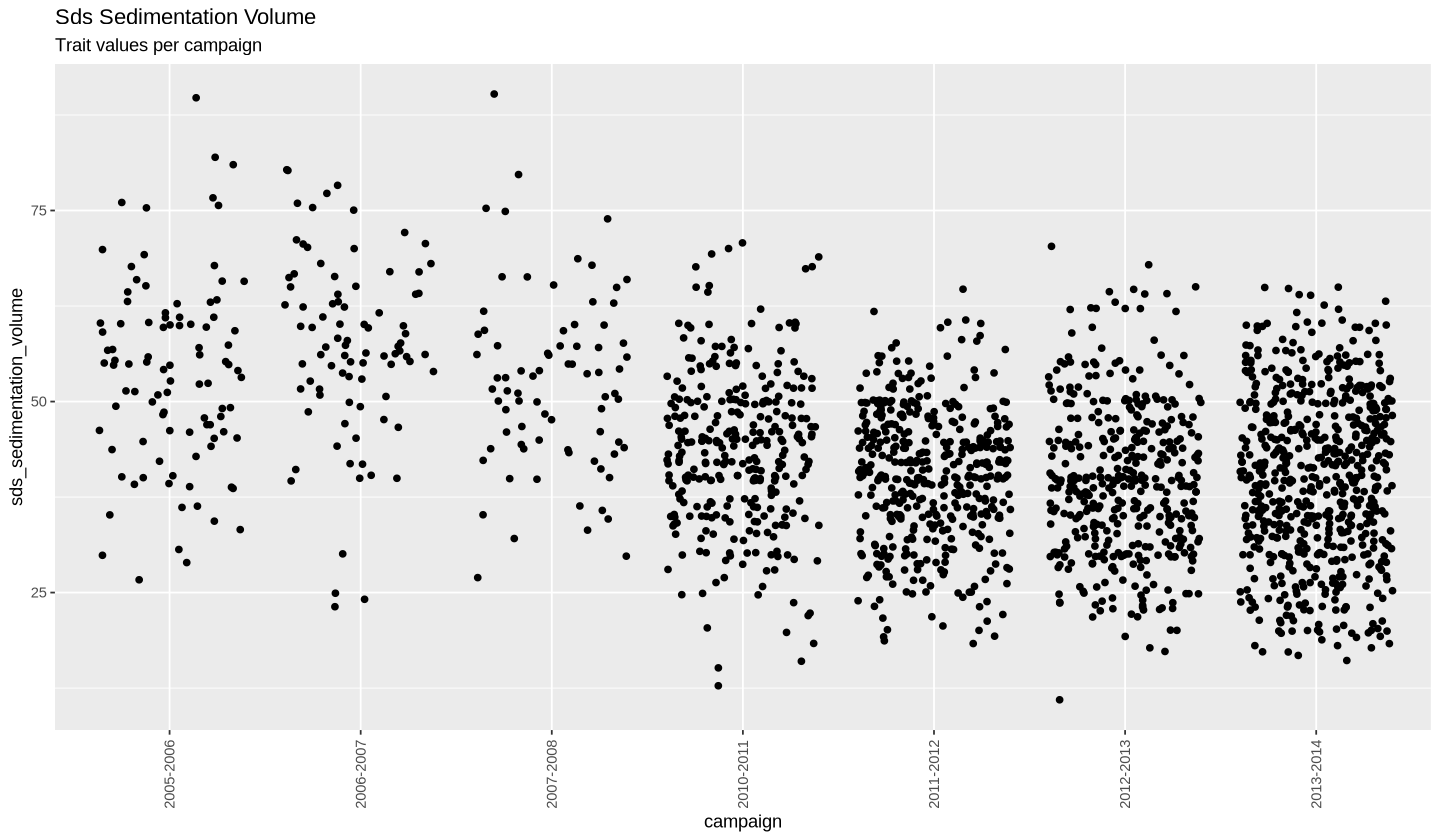

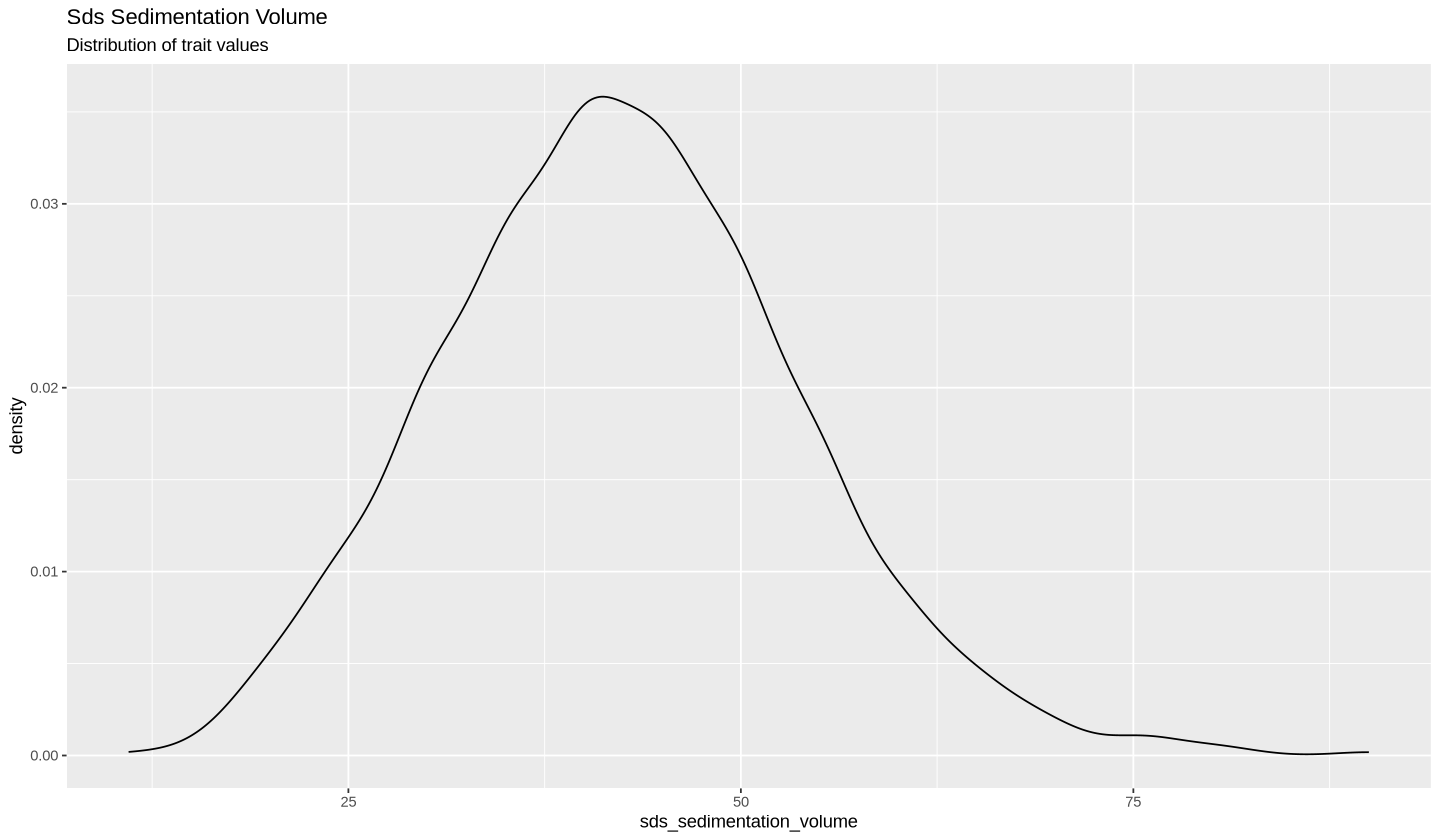

In [4]:
options(repr.plot.width=12, repr.plot.height=7)
data_sub_HT |> visualise_trait(geom_density())
data_sub_PH |> visualise_trait(geom_density())
data_sub_TKW |> visualise_trait(geom_density())
data_sub_PM |> visualise_trait(geom_histogram(bins=10))
data_sub_LR |> visualise_trait(geom_histogram(bins=10))
data_sub_ST |> visualise_trait(geom_histogram(bins=10))
data_sub_PC |> visualise_trait(geom_density())
data_sub_SV |> visualise_trait(geom_density())

## Extract and format the campaign effects

In [5]:
asreml_campaign_HT <- asreml(fixed = days_to_heading ~campaign, random = ~accenumb, 
                             na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign),
                             data = data_sub_HT)

In [6]:
asreml_campaign_PH <- asreml(fixed = plant_height ~campaign, random = ~accenumb,
                             na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                             data = data_sub_PH)

In [7]:
asreml_campaign_TKW <- asreml(fixed = thousand_kernel_weight ~campaign, random = ~accenumb,
                              na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                              data = data_sub_TKW)

In [8]:
data_sub_PM <- data_sub_PM |> filter(campaign != "2013-2014") # this campaign has all PM values equal to zero and is excluded to enable fitting the model. 
asreml_campaign_PM <- asreml(fixed = powdery_mildew ~campaign, random = ~accenumb,
                              na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                              data = data_sub_PM)

In [9]:
asreml_campaign_LR <- asreml(fixed = leaf_rust ~campaign, random = ~accenumb,
                              na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                              data = data_sub_LR)

In [10]:
asreml_campaign_ST <- asreml(fixed = septoria_tritici_ssp ~campaign, random = ~accenumb,
                              na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                              data = data_sub_ST)

In [11]:
asreml_campaign_PC <- asreml(fixed = protein_content ~campaign, random = ~accenumb,
                              na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                              data = data_sub_PC)

In [12]:
asreml_campaign_SV <- asreml(fixed = sds_sedimentation_volume ~campaign, random = ~accenumb,
                              na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                              data = data_sub_SV)

In [13]:
campaign_effect_HT <- get_campaign_effect(asreml_campaign_HT)
campaign_effect_PH <- get_campaign_effect(asreml_campaign_PH)
campaign_effect_TKW <- get_campaign_effect(asreml_campaign_TKW)
campaign_effect_PM <- get_campaign_effect(asreml_campaign_PM)
campaign_effect_LR <- get_campaign_effect(asreml_campaign_LR)
campaign_effect_ST <- get_campaign_effect(asreml_campaign_ST)
campaign_effect_PC <- get_campaign_effect(asreml_campaign_PC)
campaign_effect_SV <- get_campaign_effect(asreml_campaign_SV)

## Extract heterogeneous error variances

In [14]:
error_var_HT <- get_error_var(asreml_campaign_HT)
error_var_PH <- get_error_var(asreml_campaign_PH)
error_var_TKW <- get_error_var(asreml_campaign_TKW)
error_var_PM <- get_error_var(asreml_campaign_PM)
error_var_LR <- get_error_var(asreml_campaign_LR)
error_var_ST <- get_error_var(asreml_campaign_ST)
error_var_PC <- get_error_var(asreml_campaign_PC)
error_var_SV <- get_error_var(asreml_campaign_SV)

## Calculate and standardize the coefficient of variation (CV)

In [15]:
CV_df_HT <- make_CV_df(campaign_effect_HT, error_var_HT)
CV_df_PH <- make_CV_df(campaign_effect_PH, error_var_PH)
CV_df_TKW <- make_CV_df(campaign_effect_TKW, error_var_TKW)
CV_df_PM <- make_CV_df(campaign_effect_PM, error_var_PM)
CV_df_LR <- make_CV_df(campaign_effect_LR, error_var_LR)
CV_df_ST <- make_CV_df(campaign_effect_ST, error_var_ST)
CV_df_PC <- make_CV_df(campaign_effect_PC, error_var_PC)
CV_df_SV <- make_CV_df(campaign_effect_SV, error_var_SV)

## Remove outlier campaigns

In [16]:
data_corrected_HT_I <- data_sub_HT |> correct_I(CV_df_HT)
data_corrected_PH_I <- data_sub_PH |> correct_I(CV_df_PH)
data_corrected_TKW_I <- data_sub_TKW |> correct_I(CV_df_TKW)
data_corrected_PM_I <- data_sub_PM |> correct_I(CV_df_PM)
data_corrected_LR_I <- data_sub_LR |> correct_I(CV_df_LR)
data_corrected_ST_I <- data_sub_ST |> correct_I(CV_df_ST)
data_corrected_PC_I <- data_sub_PC |> correct_I(CV_df_PC)
data_corrected_SV_I <- data_sub_SV |> correct_I(CV_df_SV)

0 outlier campaign(s) detected for trait days_to_heading
0 outlier campaign(s) detected for trait plant_height
0 outlier campaign(s) detected for trait thousand_kernel_weight
0 outlier campaign(s) detected for trait powdery_mildew
0 outlier campaign(s) detected for trait leaf_rust
0 outlier campaign(s) detected for trait septoria_tritici_ssp
0 outlier campaign(s) detected for trait protein_content
0 outlier campaign(s) detected for trait sds_sedimentation_volume


## Residuals

In [17]:
asreml_res_HT <- asreml(fixed = days_to_heading ~ accenumb, random = ~ campaign,
                 na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                 data = data_corrected_HT_I)

In [18]:
asreml_res_PH <- asreml(fixed = plant_height ~ accenumb, random = ~ campaign, 
                 na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                 data = data_corrected_PH_I)

In [19]:
asreml_res_TKW <- asreml(fixed = thousand_kernel_weight ~ accenumb, random = ~ campaign, 
                  na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                  data = data_corrected_TKW_I)

In [20]:
asreml_res_PM <- asreml(fixed = powdery_mildew ~ accenumb, random = ~ campaign, 
                  na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                  data = data_corrected_PM_I)

In [21]:
asreml_res_LR <- asreml(fixed = leaf_rust ~ accenumb, random = ~ campaign, 
                  na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                  data = data_corrected_LR_I)

In [22]:
asreml_res_ST <- asreml(fixed = septoria_tritici_ssp ~ accenumb, random = ~ campaign, 
                  na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                  data = data_corrected_ST_I)

In [23]:
asreml_res_PC <- asreml(fixed = protein_content ~ accenumb, random = ~ campaign, 
                  na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                  data = data_corrected_PC_I)

In [24]:
asreml_res_SV <- asreml(fixed = sds_sedimentation_volume ~ accenumb, random = ~ campaign, 
                  na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                  data = data_corrected_SV_I)

300 outlier value(s) detected for trait Days To Heading 


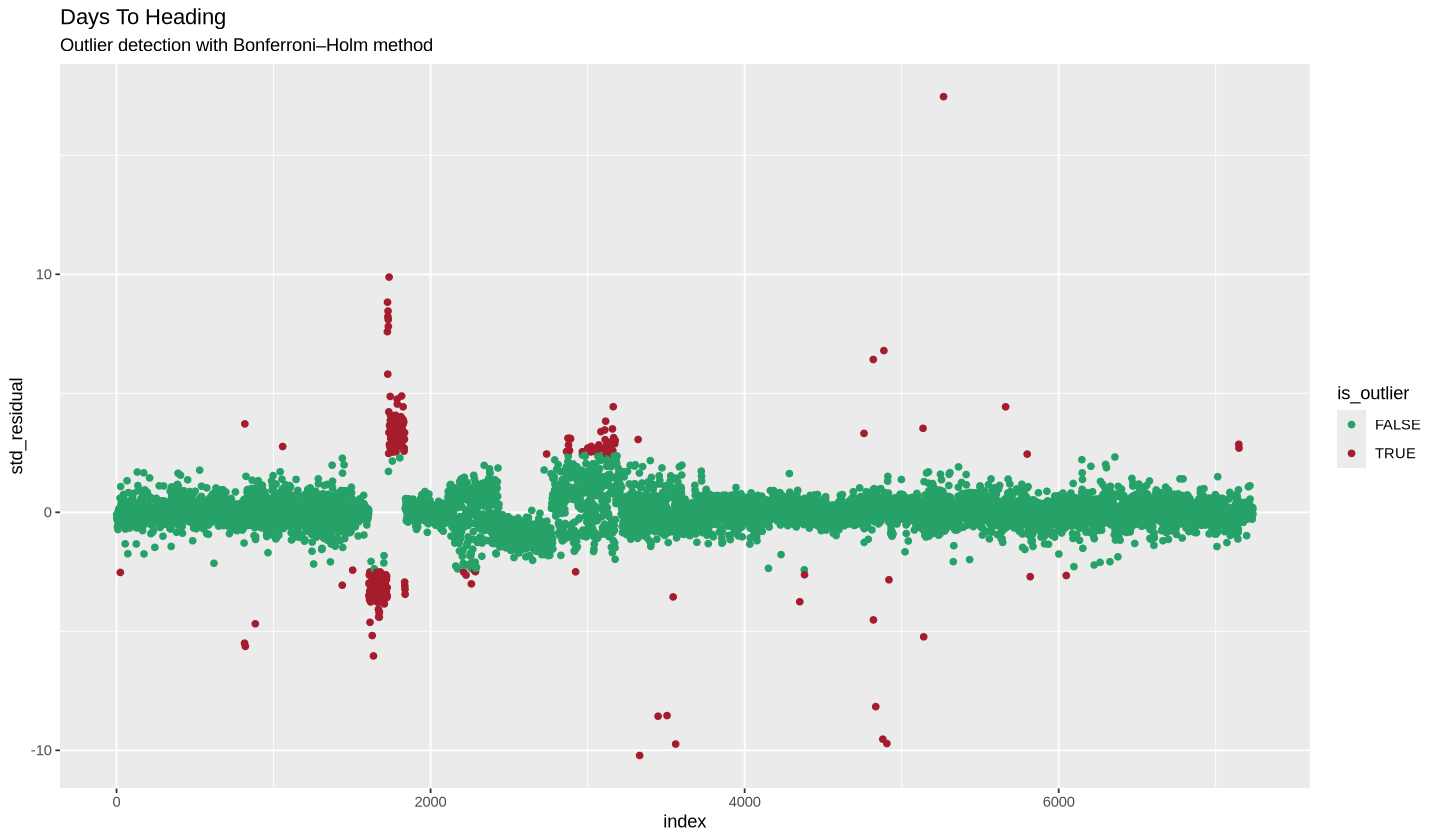

In [25]:
result_BH_HT <- make_BH_multtest(asreml_res_HT)

63 outlier value(s) detected for trait Plant Height 


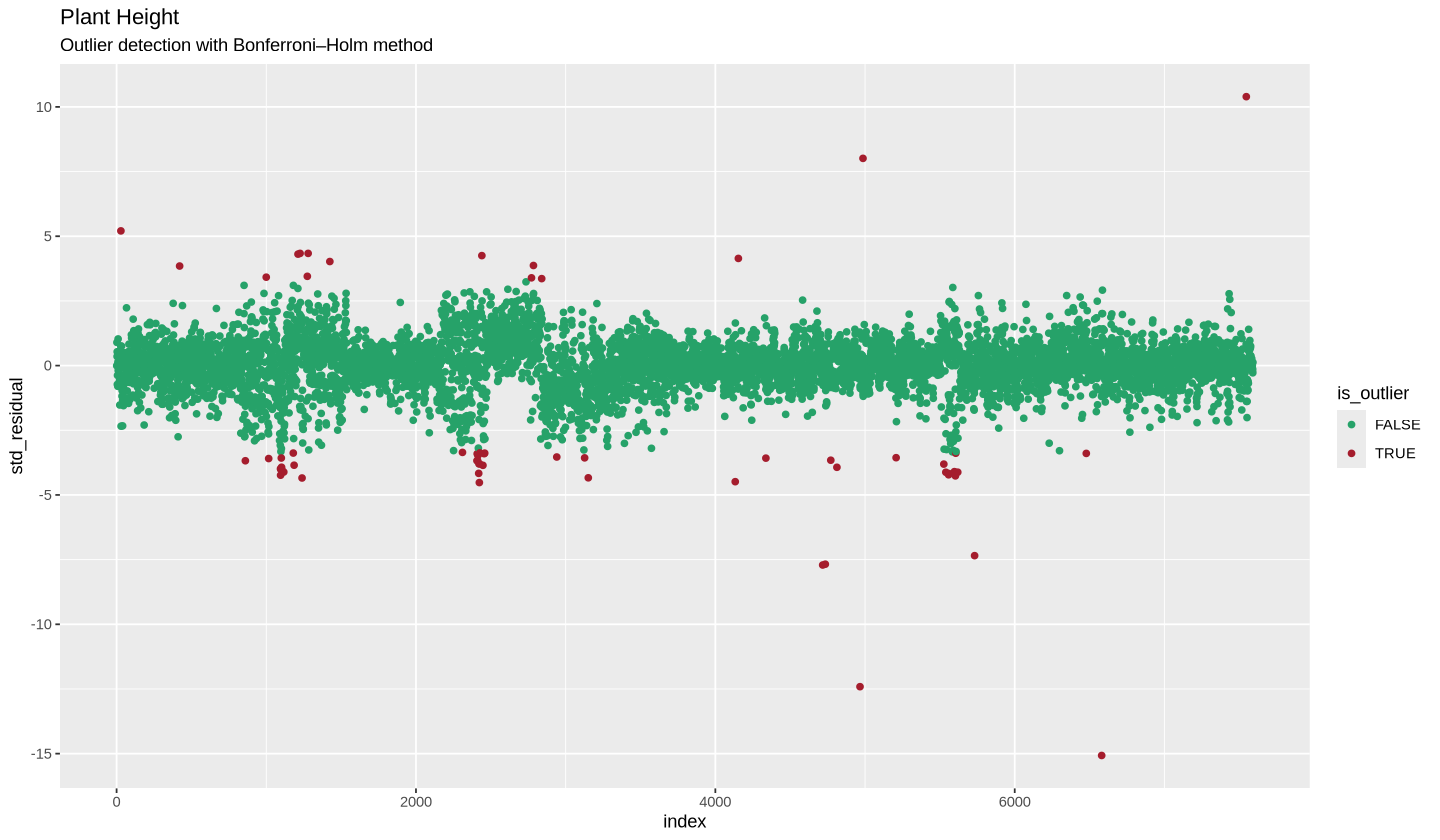

In [26]:
result_BH_PH <- make_BH_multtest(asreml_res_PH)

55 outlier value(s) detected for trait Thousand Kernel Weight 


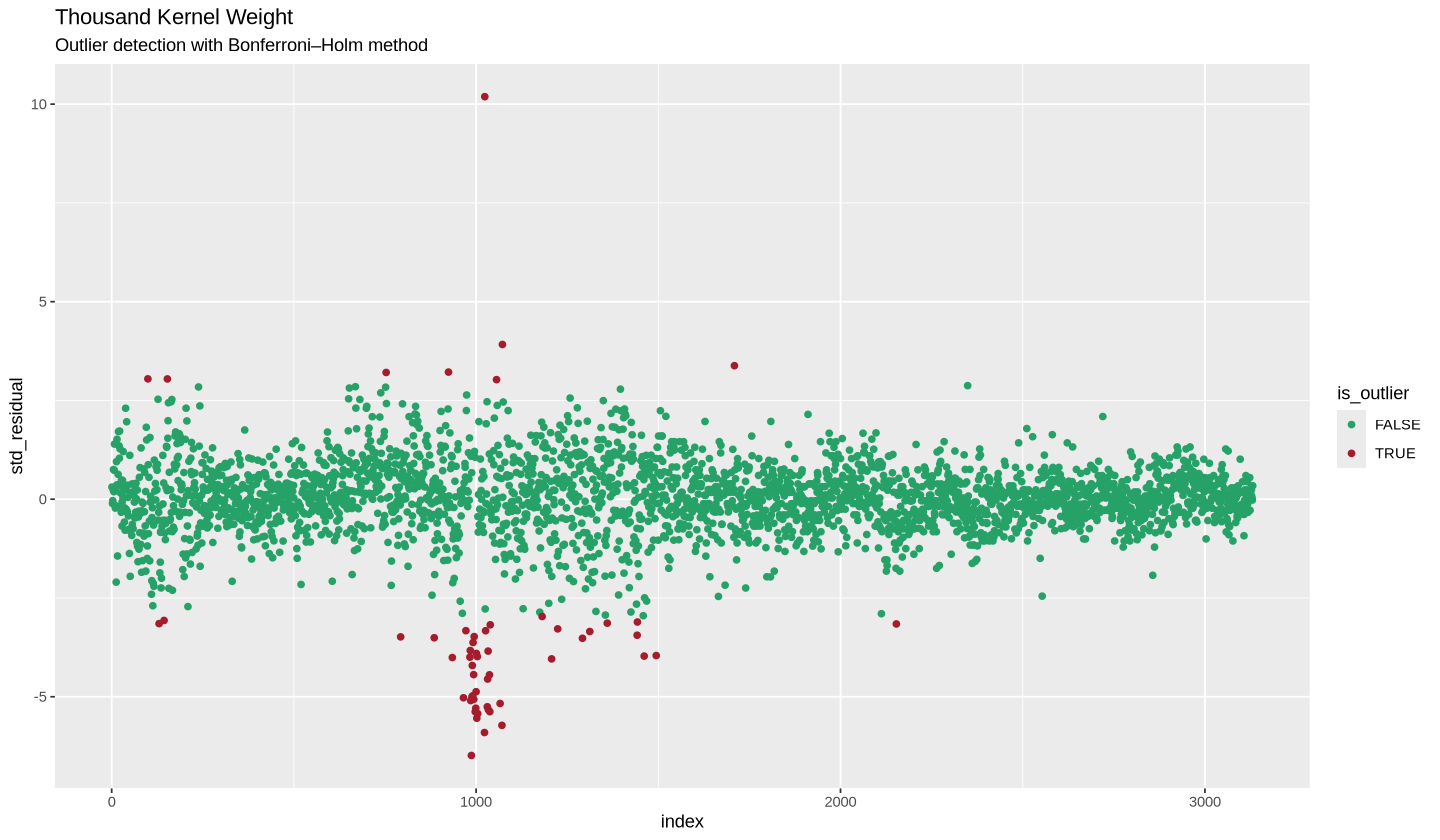

In [27]:
result_BH_TKW <- make_BH_multtest(asreml_res_TKW)

6 outlier value(s) detected for trait Powdery Mildew 


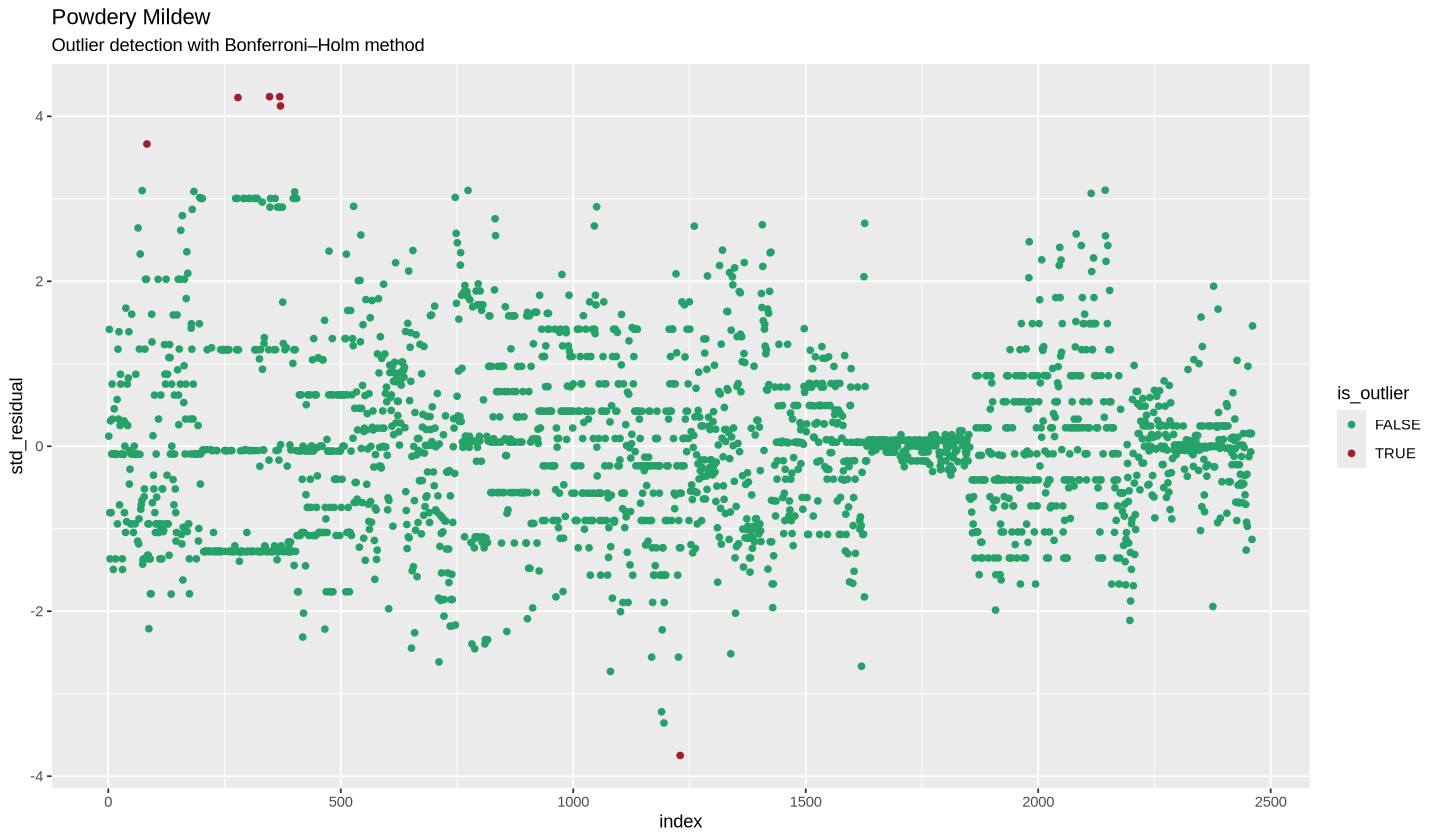

In [28]:
result_BH_PM <- make_BH_multtest(asreml_res_PM)

5 outlier value(s) detected for trait Leaf Rust 


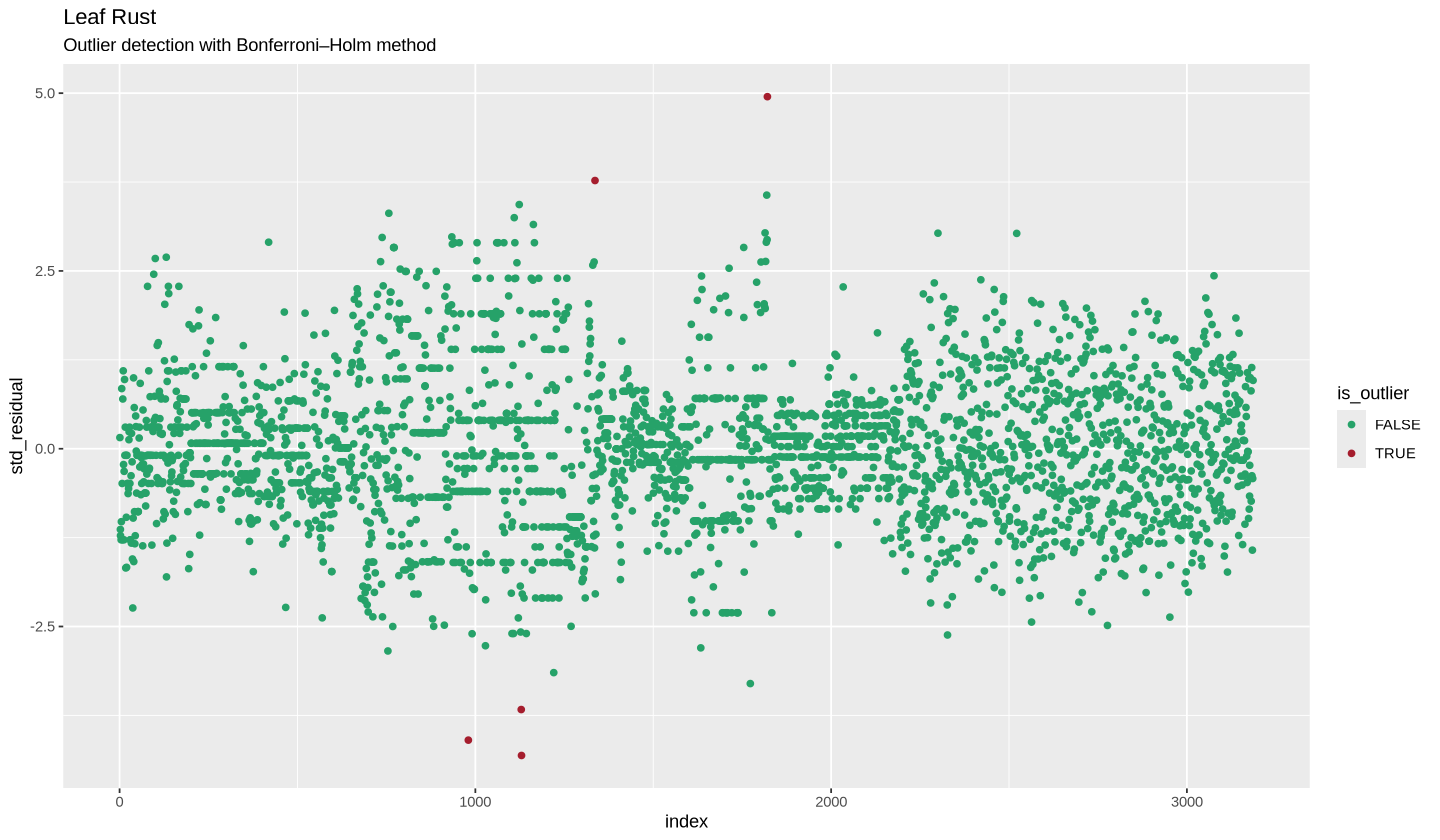

In [29]:
result_BH_LR <- make_BH_multtest(asreml_res_LR)

7 outlier value(s) detected for trait Septoria Tritici Ssp 


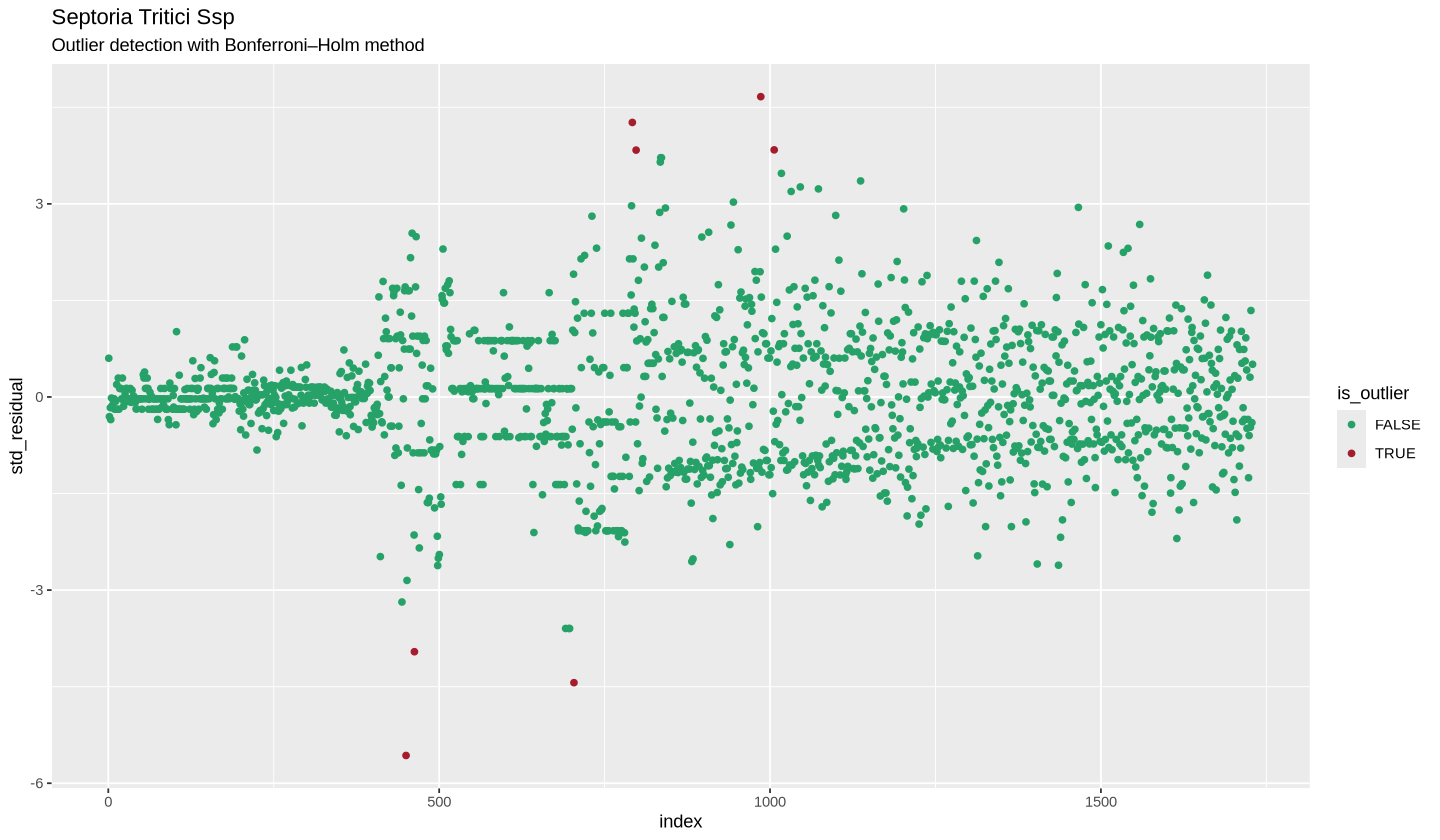

In [30]:
result_BH_ST <- make_BH_multtest(asreml_res_ST)

0 outlier value(s) detected for trait Protein Content 


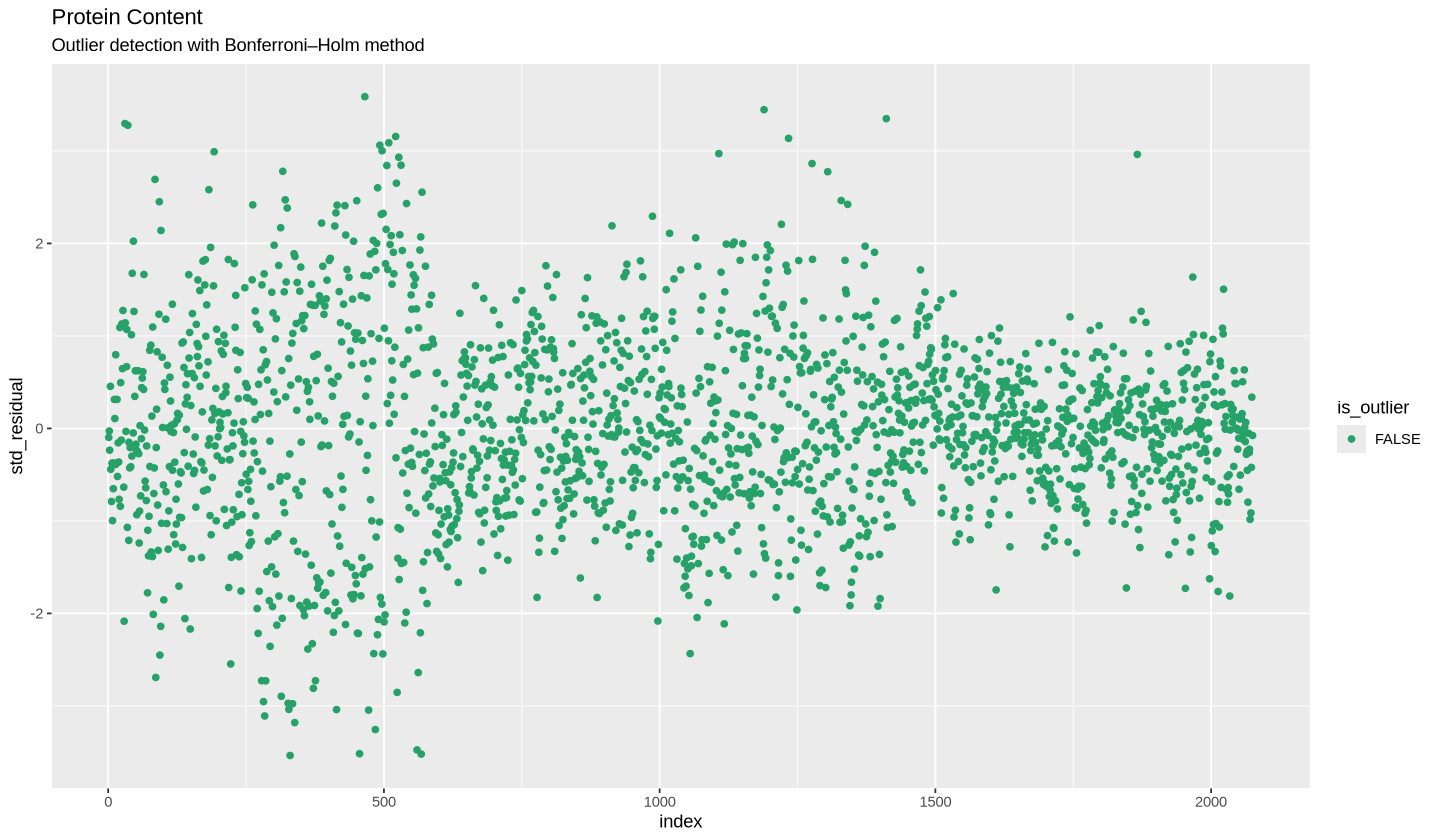

In [31]:
result_BH_PC <- make_BH_multtest(asreml_res_PC)

2 outlier value(s) detected for trait Sds Sedimentation Volume 


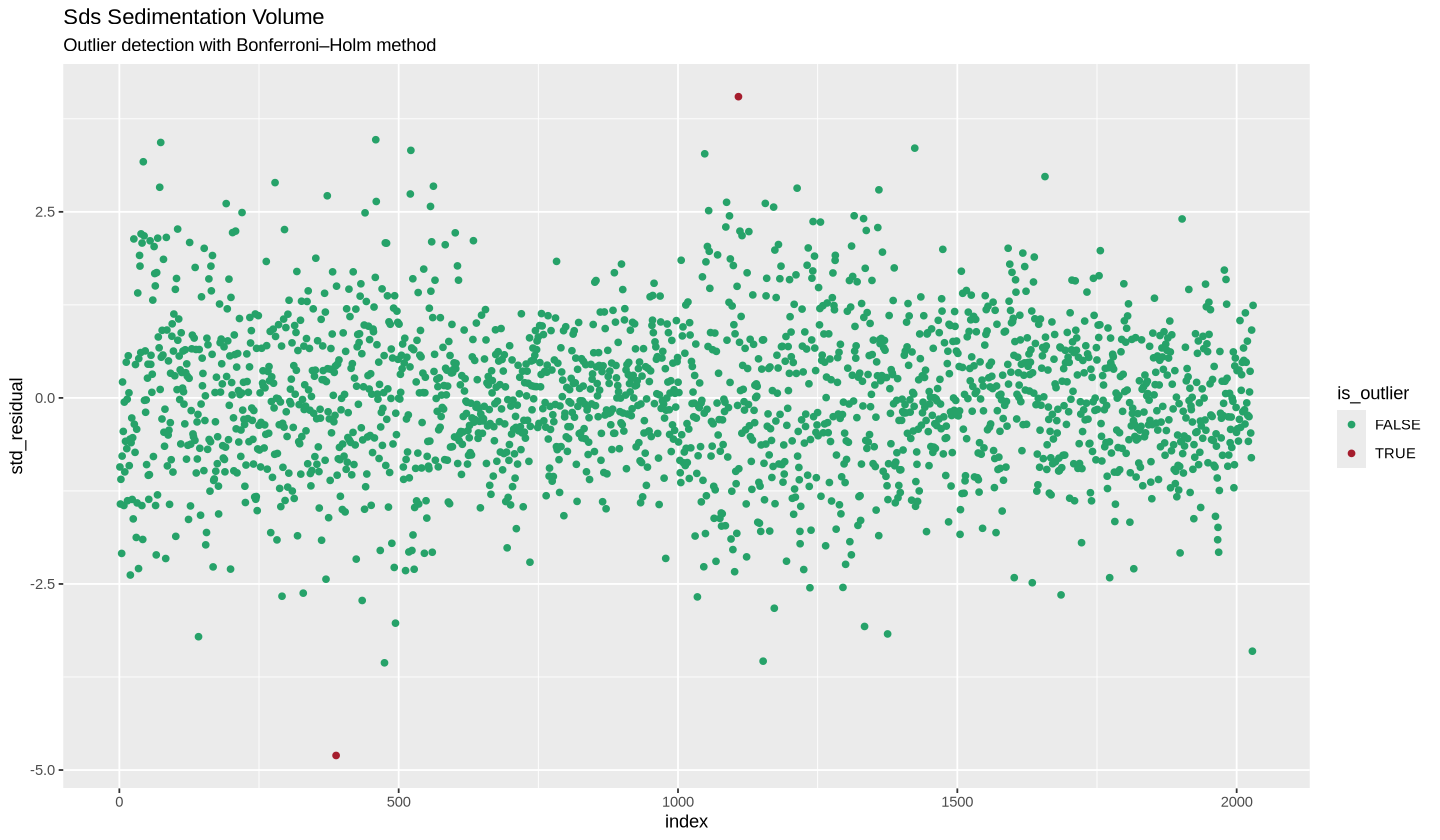

In [32]:
result_BH_SV <- make_BH_multtest(asreml_res_SV)

In [33]:
data_corrected_HT_II <- data_corrected_HT_I |> correct_II(result_BH_HT)
data_corrected_PH_II <- data_corrected_PH_I |> correct_II(result_BH_PH)
data_corrected_TKW_II <- data_corrected_TKW_I |> correct_II(result_BH_TKW)
data_corrected_PM_II <- data_corrected_PM_I |> correct_II(result_BH_PM)
data_corrected_LR_II <- data_corrected_LR_I |> correct_II(result_BH_LR)
data_corrected_ST_II <- data_corrected_ST_I |> correct_II(result_BH_ST)
data_corrected_PC_II <- data_corrected_PC_I |> correct_II(result_BH_PC)
data_corrected_SV_II <- data_corrected_SV_I |> correct_II(result_BH_SV)

## Calculate heritability

In [34]:
asreml_res_h_HT <- asreml(days_to_heading ~1, random = ~accenumb + campaign, 
                   na.action = na.method(x="omit", y="omit"), 
                   residual = ~dsum( ~id(units) | campaign), data = data_corrected_HT_II)

In [35]:
asreml_res_h_PH <- asreml(plant_height ~1, random = ~accenumb + campaign, 
                   na.action = na.method(x="omit", y="omit"), 
                   residual = ~dsum( ~id(units) | campaign), data = data_corrected_PH_II)

In [36]:
asreml_res_h_TKW <- asreml(thousand_kernel_weight ~1, random = ~accenumb + campaign, 
                    na.action = na.method(x="omit", y="omit"),
                    residual = ~dsum( ~id(units) | campaign), data = data_corrected_TKW_II)

In [37]:
asreml_res_h_PM <- asreml(powdery_mildew ~1, random = ~accenumb + campaign, 
                   na.action = na.method(x="omit", y="omit"), 
                   residual = ~dsum( ~id(units) | campaign), data = data_corrected_PM_II)

In [38]:
asreml_res_h_LR <- asreml(leaf_rust ~1, random = ~accenumb + campaign, 
                   na.action = na.method(x="omit", y="omit"), 
                   residual = ~dsum( ~id(units) | campaign), data = data_corrected_LR_II)

In [39]:
asreml_res_h_ST <- asreml(septoria_tritici_ssp ~1, random = ~accenumb + campaign, 
                   na.action = na.method(x="omit", y="omit"), 
                   residual = ~dsum( ~id(units) | campaign), data = data_corrected_ST_II)

In [40]:
asreml_res_h_PC <- asreml(protein_content ~1, random = ~accenumb + campaign, 
                   na.action = na.method(x="omit", y="omit"), 
                   residual = ~dsum( ~id(units) | campaign), data = data_corrected_PC_II)

In [41]:
asreml_res_h_SV <- asreml(sds_sedimentation_volume ~1, random = ~accenumb + campaign, 
                   na.action = na.method(x="omit", y="omit"), 
                   residual = ~dsum( ~id(units) | campaign), data = data_corrected_SV_II)

In [42]:
quality_HT <- get_quality(data_sub_HT, asreml_res_h_HT)
quality_PH <- get_quality(data_sub_PH, asreml_res_h_PH)
quality_TKW <- get_quality(data_sub_TKW, asreml_res_h_TKW)
quality_PM <- get_quality(data_sub_PM, asreml_res_h_PM)
quality_LR <- get_quality(data_sub_LR, asreml_res_h_LR)
quality_ST <- get_quality(data_sub_ST, asreml_res_h_ST)
quality_PC <- get_quality(data_sub_PC, asreml_res_h_PC)
quality_SV <- get_quality(data_sub_SV, asreml_res_h_SV)

quality_all = bind_rows(quality_HT, quality_PH, quality_TKW, quality_PM, quality_LR, quality_ST, quality_PC, quality_SV) |> 
                    mutate(across(-1, \(x) round(x, 3)))
write_csv(quality_all,"CREA_wheat_data_quality.csv")

days_to_heading heritability: 90 %
plant_height heritability: 95.2 %
thousand_kernel_weight heritability: 84.8 %
powdery_mildew heritability: 4 %
leaf_rust heritability: 38.6 %
septoria_tritici_ssp heritability: 6.7 %
protein_content heritability: 75.6 %
sds_sedimentation_volume heritability: 91.3 %


## Run linear mixed model with outlier corrected data

In [43]:
asreml_data_HT <- asreml(days_to_heading ~accenumb, random = ~campaign, 
                         na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                         data = data_corrected_HT_II)

In [44]:
asreml_data_PH <- asreml(plant_height ~accenumb, random = ~campaign, 
                         na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                         data = data_corrected_PH_II)

In [45]:
asreml_data_TKW <- asreml(thousand_kernel_weight ~accenumb, random = ~campaign, 
                          na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                          data = data_corrected_TKW_II)

In [46]:
asreml_data_PM <- asreml(powdery_mildew ~accenumb, random = ~campaign, 
                         na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                         data = data_corrected_PM_II)

In [47]:
asreml_data_LR <- asreml(leaf_rust ~accenumb, random = ~campaign, 
                         na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                         data = data_corrected_LR_II)

In [48]:
asreml_data_ST <- asreml(septoria_tritici_ssp ~accenumb, random = ~campaign, 
                         na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                         data = data_corrected_ST_II)

In [49]:
asreml_data_PC <- asreml(protein_content ~accenumb, random = ~campaign, 
                         na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                         data = data_corrected_PC_II)

In [50]:
asreml_data_SV <- asreml(sds_sedimentation_volume ~accenumb, random = ~campaign, 
                         na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                         data = data_corrected_SV_II)

## Extract BLUEs and create output file

In [51]:
BLUEs_HT <- get_BLUEs(asreml_data_HT)
BLUEs_PH <- get_BLUEs(asreml_data_PH)
BLUEs_TKW <- get_BLUEs(asreml_data_TKW)
BLUEs_PM <- get_BLUEs(asreml_data_PM)
BLUEs_LR <- get_BLUEs(asreml_data_LR)
BLUEs_ST <- get_BLUEs(asreml_data_ST)
BLUEs_PC <- get_BLUEs(asreml_data_PC)
BLUEs_SV <- get_BLUEs(asreml_data_SV)

BLUE_all <- genotypes |> left_join(BLUEs_HT, by="genotype") |> 
                        left_join(BLUEs_PH, by="genotype") |> 
                        left_join(BLUEs_TKW, by="genotype") |> 
                        left_join(BLUEs_PM, by="genotype") |>
                        left_join(BLUEs_LR, by="genotype") |> 
                        left_join(BLUEs_ST, by="genotype") |> 
                        left_join(BLUEs_PC, by="genotype") |> 
                        left_join(BLUEs_SV, by="genotype") |> 
                        arrange(genotype) |> mutate(across(-1, \(x) round(x, 2)))

write_csv(BLUE_all,"CREA_wheat_BLUE_values.csv")
summary(BLUE_all)

   genotype         days_to_heading_BLUE plant_height_BLUE
 Length:1473        Min.   :113.8        Min.   : 46.78   
 Class :character   1st Qu.:123.1        1st Qu.: 71.41   
 Mode  :character   Median :125.7        Median : 85.36   
                    Mean   :127.2        Mean   : 89.06   
                    3rd Qu.:131.3        3rd Qu.:104.82   
                    Max.   :149.4        Max.   :142.99   
                    NA's   :144          NA's   :128      
 thousand_kernel_weight_BLUE powdery_mildew_BLUE leaf_rust_BLUE 
 Min.   :22.29               Min.   :-1.56       Min.   :-0.92  
 1st Qu.:36.25               1st Qu.: 1.45       1st Qu.: 1.61  
 Median :40.25               Median : 1.97       Median : 2.30  
 Mean   :40.48               Mean   : 2.20       Mean   : 2.41  
 3rd Qu.:44.45               3rd Qu.: 2.88       3rd Qu.: 3.11  
 Max.   :68.12               Max.   : 8.66       Max.   : 8.29  
 NA's   :503                 NA's   :516         NA's   :490    
 septori

In [52]:
library(rmarkdown)
convert_ipynb("CREA-CI_historic_wheat_data_analysis.ipynb")

In [53]:
sessionInfo()

R version 4.3.3 (2024-02-29)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Fedora Linux 40.20240430.0 (Silverblue)

Matrix products: default
BLAS/LAPACK: /var/home/erwan/.conda/envs/R/lib/libopenblasp-r0.3.27.so;  LAPACK version 3.12.0

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

time zone: Europe/Paris
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] rmarkdown_2.26      asreml_4.2.0.267    Matrix_1.6-5       
 [4] multtest_2.58.0     Biobase_2.62.0      BiocGenerics_0.48.1
 [7] lubridate_1.9.3     forcats_1.0.0       stringr_1.5.1      
[10] dplyr_1.1.4         purrr_1.0.2         readr_2.1.5        
[13] tid